In [1]:
import random
from pathlib import Path
import time
import matplotlib.pyplot as plt
#%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nibabel as nib
from torch.utils.data import DataLoader
from tqdm import tqdm

from decoder_pretrain import DecoderPretrainNet
from encoder_pretrain import EncoderPretrainNet
from gloss_dminus import GlobalLossDminus
from gloss_d import GlobalLossD
from pretrain_utils import *
#from train_dataset import TrainDataset

import argparse
import json
import statistics

torch.cuda.empty_cache()

# arguments for training script
#parser = argparse.ArgumentParser()
#parser.add_argument("--config", help="string which config to use", type=str, required=True)
#parser.add_argument("--wandb_mode", help="wandb mode", type=str, default="online")
#parser.add_argument('--dataset', type = str, default = 'acdc', choices=['acdc', 'cimas'])
#args = parser.parse_args()

with open('configs/preprocessing_datasets.json') as config_file:
    config_datasets = json.load(config_file)
with open('configs/config_encoder.json') as config_file:
    config_encoder = json.load(config_file)

# init W&B
#print("Using W&B in %s mode" % 'online')
#wandb.init(project=config_encoder["model"], mode='online')
seed = config_encoder['seed']
torch.manual_seed(seed)
np.random.seed(seed)

# choose model from config
model = EncoderPretrainNet(config_encoder)

# choose specified optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config_encoder["lr"])

device = 'cpu'#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
model.to(device)
print("Running model %s" % config_encoder["model"])

training = True
n_parts = config_encoder['n_parts']
n_datasets = config_encoder['n_datasets']
n_volumes = config_encoder['n_volumes']
n_transforms = 1#config_encoder['n_transforms']
resize_size = config_encoder['resize_size']
n_channels = config_encoder['n_channels']
loss_pretraining = 'global_d' #config_encoder['loss']
batch_size = n_parts * n_datasets * n_volumes * (n_transforms+1)
perp_val = 80
max_epochs = config_encoder['max_epochs']
weight_loss = config_encoder['weight_loss']

date = str(time.strftime("%Y%h%d_%Hh%M"))
save_directory = "./train_model/Cardiac_only/2/pretraining/" + str(n_datasets) +'datasets_' + str(n_volumes) + 'volumesPerBatch/'+ loss_pretraining
save_models = save_directory + '/save_models/'
Path(save_models).mkdir(parents=True, exist_ok=True)


Using device:  cpu
Running model encoder_pretrain


In [11]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import nibabel as nib
import random

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from torchvision import transforms
import torchvision.transforms.functional as TF


class PreTrainDataset(torch.utils.data.Dataset):
    def __init__(self, cfg_encoder, datasets):
        
        self.filenames = datasets
        #for dataset in self.filenames :
            #print(dataset)
            
        self.n_datasets = len(self.filenames)
        
        max_n_volumes = 0
        for i in range(len(self.filenames)) :
            self.n_volumes = max( max_n_volumes, len(self.filenames[i]) )
            
        self.n_parts = cfg_encoder['n_parts'] 
    
    def get_images_from_partitions(idx) :
        
        self.vol_indices = np.zeros((self.n_datasets, self.n_volumes, self.n_parts),dtype =int)
        for i in range(self.n_datasets) :
            for j in range(len(self.filenames[i])) :
                self.vol_indices[i][j] = get_index_partitions(self.filenames,i,j, self.n_parts)
                
    def sample_minibatch_for_global_loss(self,dataset, idx): 
        
        vol_indice = get_index_partitions(self.filenames, dataset, idx, self.n_parts)
        #vol_indice = self.vol_indices[dataset][idx]
        vol_file = self.filenames[dataset][idx]
        volume = nib.load(vol_file).get_fdata()
        #print(vol_indice)
        return volume[:, :, vol_indice].transpose(2, 0, 1)

    def __len__(self):
        return self.n_volumes

    def __getitem__(self, idx):
        
        for dataset in range(len(self.filenames)) :
            if idx >= len(self.filenames[dataset]):
                    lower_idx = random.randrange(len(self.filenames[dataset]))
            else : lower_idx = idx
            
            new_slices = self.sample_minibatch_for_global_loss(dataset, lower_idx)
            
            i = random.randint(0, 10)
            
            if dataset == 0 :
                slices = new_slices                
            else :
                slices = np.concatenate((slices, new_slices), axis=0)  
        return slices
    
    

def get_index_partitions(filenames, i, j, n_parts): 
    
    vol_file = filenames[i][j]
    volume = nib.load(vol_file).get_fdata()
#     print('vol_file',vol_file)
    n_slices = volume.shape[2]
    # starting index of first partition of any chosen volume
    partition_lengths = [0]
    # find the starting and last index of each partition in a volume based on input image size. 
    # shape[0] indicates total no. of slices in axial direction of the input image.
    for k in range(1, n_parts + 1):
        partition_lengths.append(k * int(n_slices / n_parts))
    
#     print('n_slices, partition_lengths',n_slices, partition_lengths)
    
    # Now sample 1 image from each partition randomly. Overall, n_parts images for each chosen volume id.
    idces = []
    for k in range(0, len(partition_lengths) - 1):
        # sample image from each partition randomly
        i_sel = random.sample(range(partition_lengths[k], partition_lengths[k + 1]), 1)
#         print('i_sel',i_sel)
        idces.append(i_sel[0])
    
#     print('idces',idces)
    
    return idces
    
class custom_transforms(object):

    def __init__(self, cfg_encoder) :
        #assert isinstance(output_size, (int,tuple))
        self.output_size = cfg_encoder['resize_size']
        
    def __call__(self, image, dtype ='train'):
        img_initial = image
        resize = transforms.Resize(size = self.output_size)
        image = resize(image)
        
        brightness_factor = np.random.uniform(0, 0.3,image.shape[0])
        contrast_factor = np.random.uniform(0.7, 1.3,image.shape[0])
        #Random crop
        #mask = TF = crop(mask,i,j,h,w)

        return_images = image
        for idx in range(image.shape[0]):
            #define a crop size for the current image
            crop_size = [int(random.uniform(3*image.shape[2]/4,image.shape[2])), \
                         int(random.uniform(3*image.shape[3]/4, image.shape[3]))]
            i,j,h,w = transforms.RandomCrop.get_params(image[idx,:,:,:], output_size=crop_size)
            # to crop from the center adjust start of the crop:
            #i , j = int((self.output_size[0] - h)/2), int((self.output_#ize [1] - w)/2)
            #i, j = int(random.uniform(20,40)),  int(random.uniform(20,40))
            i = 0
            j = int(random.uniform(20,40))
            cropped_img = TF.crop(image[idx],i,j,h,w)
            
            return_images [idx,:,:,:]= resize(cropped_img)
            # adjust contrast and brightness
            return_images[idx,:,:,:] = return_images[idx,:,:,:] * contrast_factor[idx] + brightness_factor[idx]        
            
            # Keep all values between 0 and 1.5
            return_images[idx,:,:,:] = torch.clamp(return_images[idx,:,:,:], 0, 1.5) 
        
        # Show image and its transform
        #volume[:,:,idx_image] = image
        for i in range(5):
            fig, axs = plt.subplots(1, 2)
            axs[0].imshow(img_initial[i,0,:,:])
            axs[1].imshow(return_images[i,0,:,:])
    
        return return_images# volume #, mask
    
    def __repr__(self):
        return self.__class__.__name__+'()'

    



  0%|          | 0/3 [00:00<?, ?it/s]

Doing Train...
Epoch 000


100%|██████████| 3/3 [00:11<00:00,  3.67s/it]

Current train loss: 7.422999


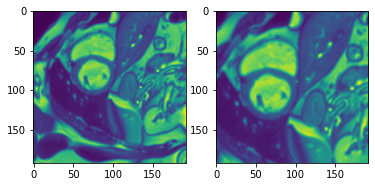

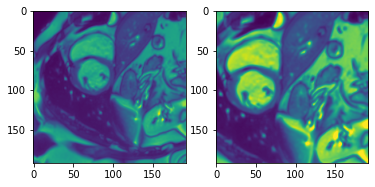

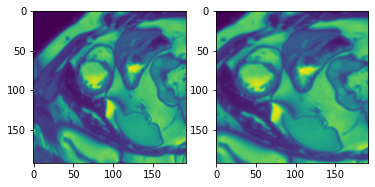

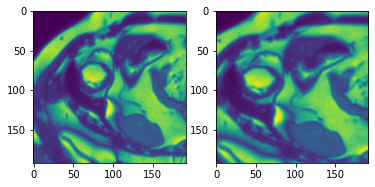

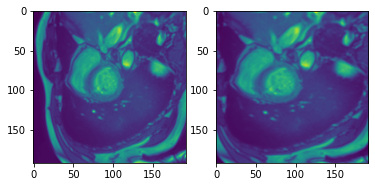

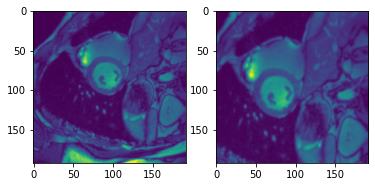

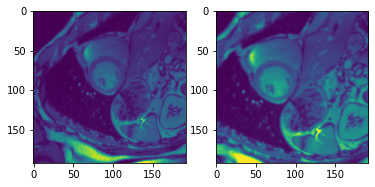

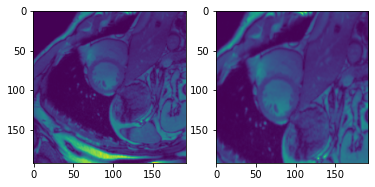

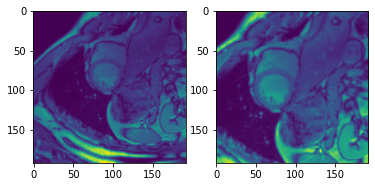

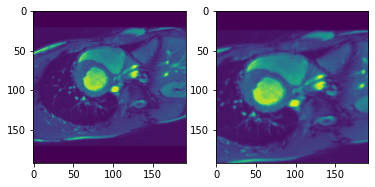

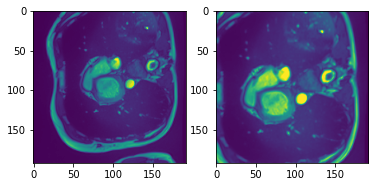

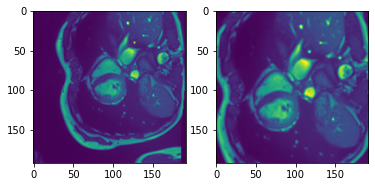

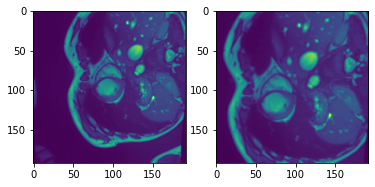

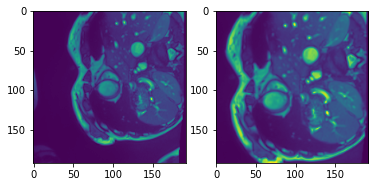

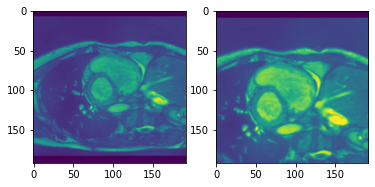

In [12]:
# Dataset Initialization

datasets_train = []
datasets_validation = []

for config_dataset in config_datasets:
    #if config_dataset['experiment'] ==  "preprocessing":
    if config_dataset['Data'] == 'ACDC' :
        current_datasets_train = []
        current_datasets_validation = []

        for path in Path( config_dataset["savedir"]).rglob( "train/*/img.nii.gz"):
            current_datasets_train.append(path)
        for path in Path( config_dataset["savedir"]).rglob( "validation/*/img.nii.gz"):
            current_datasets_validation.append(path)
        datasets_train.append(current_datasets_train)
        datasets_validation.append(current_datasets_validation)

#print(datasets_train)

dataset_train = PreTrainDataset(config_encoder, datasets_train)
dataset_loader_train = DataLoader(dataset_train,
                            num_workers=1,
                            batch_size=config_encoder['batch_size'],
                            pin_memory=True,
                            shuffle=True,
                            drop_last=True)

dataset_validation = PreTrainDataset(config_encoder, datasets_validation)
dataset_loader_validation = DataLoader(dataset_validation,
                            num_workers=1,
                            batch_size=config_encoder['batch_size'],
                            shuffle=False,
                            drop_last=False)


trans = custom_transforms(config_encoder)

steps = 0
losses = pd.DataFrame(columns = ['epoch', 'train loss', 'validation loss'])

# Training
max_epochs=1
for epoch in range(max_epochs) :
    print("Doing Train...")
    print("Epoch {:03d}".format(epoch))

    model.train()
    batch_train_loss = []
    directory_predictions = str(save_directory) + "/predictions/" + str(epoch) +"/" 
    Path(directory_predictions).mkdir(parents=True, exist_ok=True)
    for id_batch, batch_x in enumerate(tqdm(dataset_loader_train)):

        optimizer.zero_grad()
        criterion =  GlobalLossD(config_encoder)
        # augment batches by random two separate random transforms

        batch = batch_x.float().to(device)
        batch = batch.view((-1, n_channels, *resize_size))
        train_batch = batch.to(device)
               
        #print('device ', device)
        #print('train batch size ', train_batch.shape)
        #if loss_pretraining == 'global_dminus' :
        if loss_pretraining == 'global_d' :
            for i in range(n_transforms) :
                train_batch = torch.cat([train_batch, trans(batch)])
        
        
        
        #optimizer.zero_grad(set_to_none=True)
        pred = model(train_batch)
        pred = pred.squeeze()
        if id_batch == 0 :
            pred_train = pred
        else :
            pred_train = torch.cat([pred_train, pred.detach()])
        torch.save(pred_train, directory_predictions+ "pred_train.pt")
        # this is loss for pretraining
        
        loss = criterion(pred)
        batch_train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    train_loss = statistics.mean(batch_train_loss)
    #wandb.log({"train loss": train_loss, 'epoch': steps})

    print("Current train loss: %f" % train_loss)  

    
    batch_val_loss = []

In [4]:
img_batch = np.asarray(train_batch)

In [5]:
img_batch.shape

(64, 1, 192, 192)

IndexError: index 64 is out of bounds for axis 0 with size 64

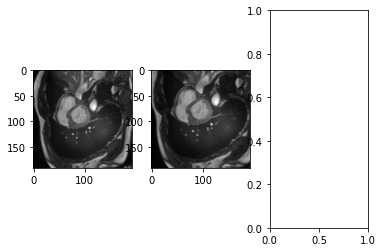

In [6]:
i=0
for i in range(0,5):
    plt.figure()
    plt.subplot(131)
    plt.imshow(img_batch[i,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(img_batch[32+i,0],cmap='gray')
    plt.subplot(133)
    plt.imshow(img_batch[64+i,0],cmap='gray')

In [ ]:
i=0
for i in range(0,5):
    plt.figure()
    plt.subplot(131)
    plt.imshow(img_batch[i,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(img_batch[32+i,0],cmap='gray')
    plt.subplot(133)
    plt.imshow(img_batch[64+i,0],cmap='gray')

In [ ]:
image=np.copy(img_batch[0,:,:,:])
print(image.shape)
print(image)
image = torch.tensor(image)

In [ ]:
output_size=[192,192]

In [ ]:
idx=0
for i in range(0,2):
    #crop_size = [int(random.uniform(2*192/3,192)), \
    #                     int(random.uniform(2*192/3,192))]
    #crop_size = [int(random.uniform(3*image.shape[1]/4,image.shape[1])), \
    #             int(random.uniform(3*image.shape[2]/4, image.shape[2]))]
    crop_size = [int(3*image.shape[1]/4), int(3*image.shape[1]/4)]
    i,j,h,w = transforms.RandomCrop.get_params(image[:,:,:], output_size=crop_size)
    # to crop from the center adjust start of the crop:
    #i , j = int((output_size[0] - h)/2), int((output_size [1] - w)/2)
    i, j = int(random.uniform(0,20)),  int(random.uniform(0,20))
    cropped_img = TF.crop(image[idx],i,j,h,w)
    print(crop_size)
    print(i,j,h,w)
    cropped_img = TF.crop(image[idx],i,j,h,w)
    print('cropped_img',cropped_img.shape)
    plt.figure()
    plt.imshow(np.squeeze(cropped_img),cmap='gray')